## Week 5: Image Classification using a Predefined Model and Input Pipelines

We have two goals in this notebook:

1. We'll demonstrate how to perform image classification using a **predefined convolutional neural network**, specifically `MobileNetV2`, a lightweight and efficient model often used in mobile and edge applications.

2. We’ll use a dataset from **TensorFlow Datasets (TFDS)** and build an efficient **input pipeline** using the `tf.data` API to stream, preprocess, and batch the data.


Throughout the notebook, we’ll explore different hyperparameter settings and architectural options for using MobileNetV2 as a base model, including strategies for transfer learning and fine-tuning.




In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import os
import time
import math
import collections


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Input, models, callbacks, regularizers, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import Callback,LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay


# utility code

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


'''  How to time your code
# start timer
start_time = time.time()

<your code here> 

# Record end time and print execution time
print(f"Execution Time: " + format_hms(time.time()-start_time))
'''

random_seed = 42

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

notebook_start = time.time()

In [2]:
# Utility to print learning curves

results = {}

def plot_learning_curves(hist, 
                         title="Learning Curves", 
                         best_epoch=None,              # None = print absolute minimum val_loss point on both plots
                                                       # else assume is 0-based early stopping trigger point
                         verbose=True
                        ):

    val_losses = hist.history['val_loss']
    
    if best_epoch:
        min_val_epoch = best_epoch
    else:
        min_val_epoch = val_losses.index(min(val_losses))
        
    val_loss_at_min_loss = hist.history['val_loss'][min_val_epoch]    
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    n_epochs = len(val_losses)
    epochs = list(range(1, n_epochs + 1))

    # Determine tick interval and xticks starting from 0

    tick_interval = max(1, n_epochs // 20)
    xticks = list(range(0, n_epochs + 1, tick_interval))

    plt.figure(figsize=(8, 8))

    # --- Loss Plot ---
    plt.subplot(2, 1, 1)
    plt.plot(epochs, hist.history['loss'], label='Train Loss')
    plt.plot(epochs, hist.history['val_loss'], label='Val Loss')
    plt.scatter(min_val_epoch + 1, val_loss_at_min_loss, color='red', marker='x', s=50, label='Min Val Loss') 
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xticks(xticks)
    plt.legend()
    plt.grid(True)

    # --- Accuracy Plot ---
    plt.subplot(2, 1, 2)
    plt.plot(epochs, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, hist.history['val_accuracy'], label='Val Accuracy')
    plt.scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='Acc @ Min Val Loss')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim(0, 1.05)
    plt.xticks(xticks)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {val_loss_at_min_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss, min_val_epoch + 1)

#### Load TensorFlow Flowers Dataset

In [3]:
# Uncomment first time you run this

#!pip install tensorflow-datasets

In [4]:
# Load dataset as TF Dataset 

# Config
IMG_SIZE = (224, 224)
batch_size = 64
shuffle_buffer = 1024

# Load raw splits (no batching here!)
(raw_train, raw_val), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)   # gives floats in [-1, +1]
    return image, label               # labels stay as integer class IDs

# Build your tf.data pipelines, with exactly one .batch(...) each
train_ds = (
    raw_train
    .shuffle(shuffle_buffer)
    .map(preprocess,   num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)                   # ← only one batch here
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    raw_val
    .map(preprocess,   num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)                   # ← only one batch here
    .prefetch(tf.data.AUTOTUNE)
)

# Optional: get class names from ds_info if available
num_samples = ds_info.splits['train'].num_examples
class_names = ds_info.features['label'].names  # ['dandelion', 'daisy', ...]
num_classes = ds_info.features['label'].num_classes
print('\n',num_samples, num_classes, class_names)


 3670 5 ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


#### Explanation of TensorFlow Dataset

1. **`train_ds` is a `tf.data.Dataset` object**

   * Concretely it’s a `SplitDataset` under the hood, representing the first 80% of the `'train'` split of the `tf_flowers` dataset.
   * It does *not* hold all the data in memory; instead it defines a pipeline that will load and yield examples on demand.

2. **Elements are 2-tuples `(image, label)`**

   * Because you set `as_supervised=True`, each element is:

     ```python
     (image, label)
     ```

     * `image` is a `tf.Tensor` of shape `[224, 224, 3]` and dtype `tf.uint8` (raw pixel values).
     * `label` is a scalar `tf.Tensor` of dtype `tf.int64`, giving the class index (0:'dandelion', 1:'daisy', 2:'tulips', 3:'sunflowers', 4:'roses').

3. **Dataset metadata in `ds_info`**

   * `ds_info` is a `tfds.core.DatasetInfo` object containing things like:

     * `ds_info.splits['train'].num_examples` → total number of examples in the full train split
     * `ds_info.features['label'].num_classes` → number of classes
     * `ds_info.features['label'].names` → human-readable class names


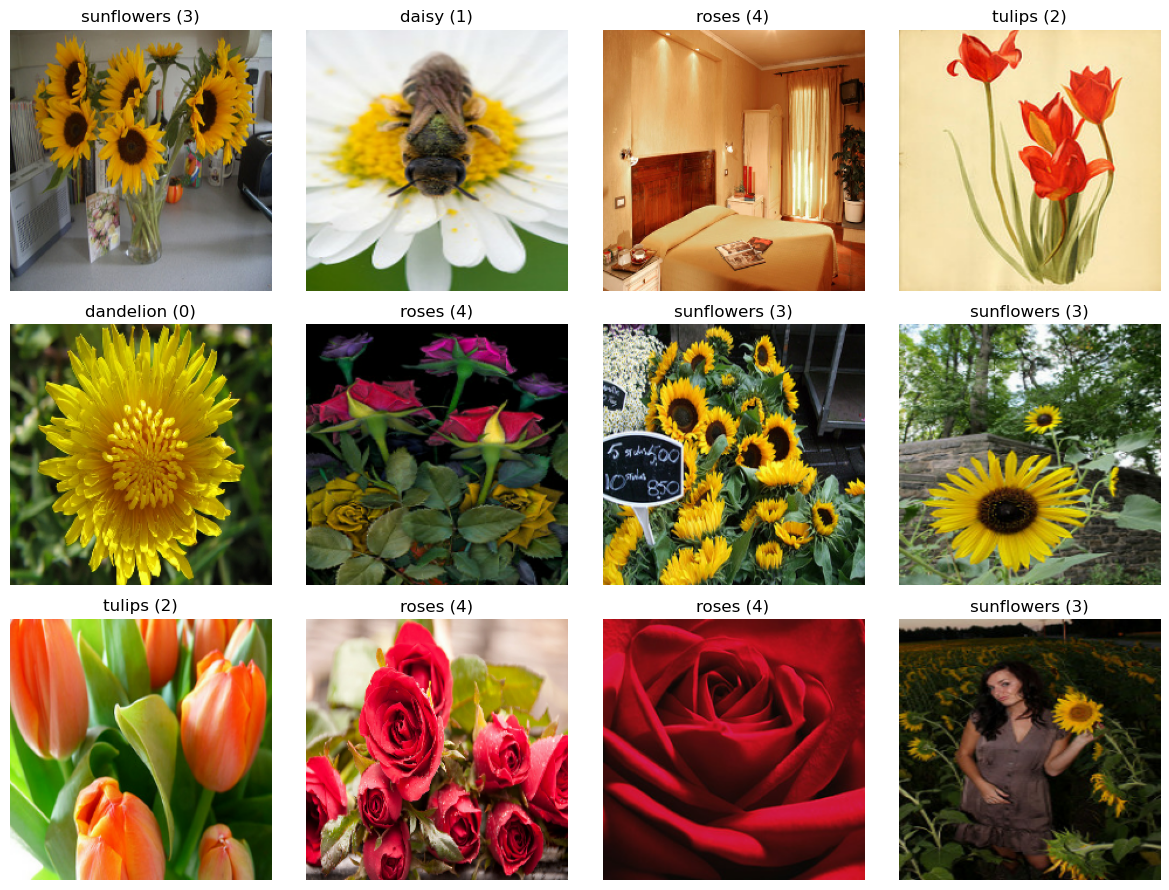

In [5]:
def show_preproc_samples(dataset, class_names=None, n=12, grid_shape=(4, 3)):
    cols, rows = grid_shape
    plt.figure(figsize=(cols*3, rows*3))

    # unbatch so we get single images
    ds = dataset.unbatch()

    for i, (img, label) in enumerate(ds.take(n)):
        # img is float32 in approx [–1, +1]:
        img_disp = (img + 1.0) * 127.5            # now in [0, 255]
        img_disp = tf.cast(img_disp, tf.uint8)    # uint8 for plt

        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img_disp.numpy())
        if class_names:
            plt.title(f"{class_names[label.numpy()]} ({label.numpy()})")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    

# then
show_preproc_samples(train_ds, class_names=class_names, n=12)



#### Check for imbalances

In [6]:

# Load the tf_flowers dataset
ds, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
full_ds = ds['train']

# Count samples per class
label_counts = collections.Counter()
for _, label in tfds.as_numpy(full_ds):
    label_counts[int(label)] += 1

# Print class distribution
print("Class Distribution:")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")



Class Distribution:
Class 0: 898 samples
Class 1: 633 samples
Class 2: 799 samples
Class 3: 699 samples
Class 4: 641 samples


**Answer: Slightly imbalanced, but usually not worth rebalancing in such a case.** 

### Callbacks

In [7]:
# Globals: Needed by lr schedulers

epochs = 100

In [8]:
# Reduce on Plateau, Exponential Decay, and Cosine Decay

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-7,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

steps_per_epoch = int(np.ceil(len(train_ds) / batch_size))
total_steps = epochs * steps_per_epoch

exp_decay = ExponentialDecay(
    initial_learning_rate=0.001,  # ─ the starting learning rate (before any decay)
    decay_steps=total_steps,     # ─ how many training steps (batches) before applying decay
    decay_rate=0.96,             # ─ multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,             # ─ if True, decay in discrete intervals (floor(step/decay_steps)),
                                 #   if False, decay smoothly each step
)

cosine_decay = CosineDecay(
    initial_learning_rate=0.001,   # ─ the starting learning rate
    decay_steps=total_steps,            # ─ number of training steps (batches) over which to decay
    alpha=0.0,                    # ─ minimum learning rate value as a fraction of initial_learning_rate
                                  #    (final_lr = initial_lr * alpha)
)

### Wrapper to Run Experiments with Models

In [9]:
# train and test

def train_and_test(model, 
                   train_ds,
                   val_ds,
                   epochs         = 100,
                   lr_schedule    = 0.0001,
                   optimizer      = "Adam",
                   title          = "Learning Curves",
                   use_early_stopping = True,
                   patience       = 10,
                   min_delta      = 0.0001,
                   callbacks      = [],
                   verbose        = 0,
                   return_history = False
                  ):

    print(f"{title}:  ", end='')
    if lr_schedule != 0.0001:
        print(f'lr_schedule: {lr_schedule}', end='')
    if patience != 10:
        print(f'\tpatience: {patience}', end='')
    if min_delta != 0.0001:
        print(f'\tmin_delta: {min_delta}', end='')
    if callbacks != []:
        print(f'\tcallbacks: {callbacks}', end='')
    print('\n')

    # Optimizer
    opt = Adam(learning_rate=lr_schedule) if optimizer == "Adam" else optimizer

    # Compile model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",  # adjust if labels are sparse
                  metrics=["accuracy"])

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )

    cbs = [early_stop] + callbacks if use_early_stopping else callbacks

    # Train
    start = time.time()
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs,
                        callbacks=cbs,
                        verbose=verbose)

    best_epoch = early_stop.best_epoch
    best_acc = history.history['val_accuracy'][best_epoch]

    plot_learning_curves(history, title=title, best_epoch=best_epoch)

    # Evaluate (optional test set must be passed separately)
    print(f"\nFinal Validation Accuracy: {best_acc:.4f}")
    print(f"Best Epoch: {best_epoch + 1}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end - start))

    if return_history:
        return history


### Model 1: MobileNetV2 with Frozen Layers and Simple Head

We will use as our baseline the MobileNetV2 model with only average pooling and softmax output in the final layers. 

MobileNetV2 Frozen:  



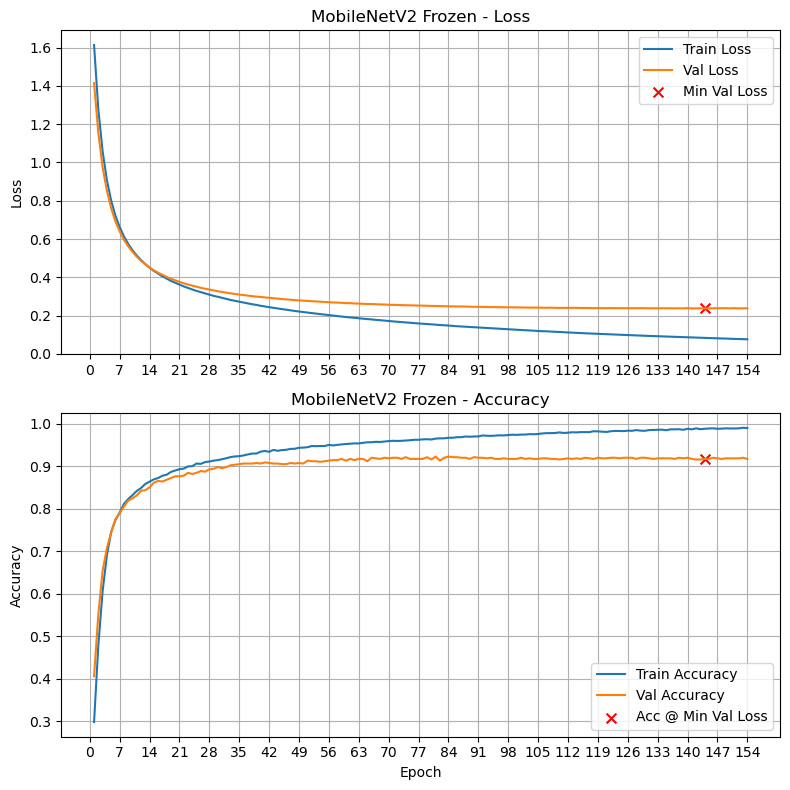

Final Training Loss:            0.0762
Final Training Accuracy:        0.9894
Final Validation Loss:          0.2382
Final Validation Accuracy:      0.9169
Minimum Validation Loss:        0.2374 (Epoch 144)
Validation Accuracy @ Min Loss: 0.9169

Final Validation Accuracy: 0.9169
Best Epoch: 144

Execution Time: 00:05:39


In [10]:
# Load MobileNetV2 base
base_model1 = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3)
                        )

base_model1.trainable = False  # Freeze base

# Add classification head
model_01 = models.Sequential([base_model1,
                               layers.GlobalAveragePooling2D(),                 # See explanation below
                               layers.Dense(num_classes, activation='softmax')  
                              ])


# print(train_ds.element_spec)

train_and_test(model_01, 
               train_ds,
               val_ds,
               lr_schedule=1e-4,
               epochs=200,
               title="MobileNetV2 Frozen"
              )


### Model 2: MobileNetV2 with Frozen Layers and Larger Head

MobileNetV2 Frozen & Larger Head with Dropout:  



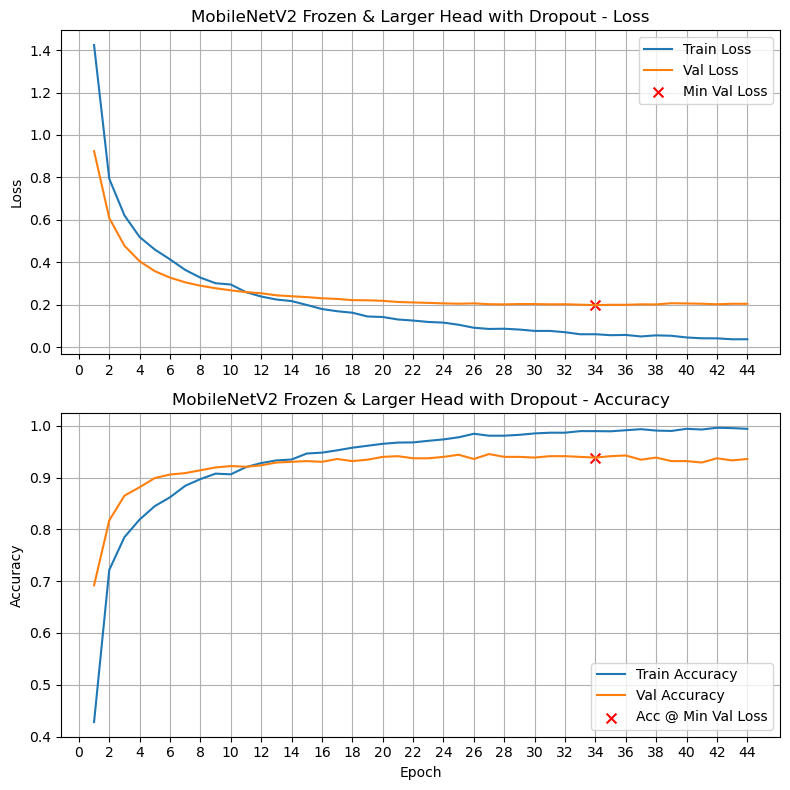

Final Training Loss:            0.0368
Final Training Accuracy:        0.9942
Final Validation Loss:          0.2038
Final Validation Accuracy:      0.9360
Minimum Validation Loss:        0.1979 (Epoch 34)
Validation Accuracy @ Min Loss: 0.9387

Final Validation Accuracy: 0.9387
Best Epoch: 34

Execution Time: 00:01:57


In [17]:
base_model2 = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3)
                        )

base_model2.trainable = False  # Freeze base

model_2 = models.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_2, train_ds, val_ds,
               lr_schedule=1e-4,
               epochs=epochs,
               title="MobileNetV2 Frozen & Larger Head with Dropout"
              )

### Model 3: MobileNetV2 with All Layers Retrained

All layers of the pretrained base are retrained, starting from the pretrained weights. This is full fine-tuning, and it's powerful but slower and riskier on small datasets.

MobileNetV2 All Layers Retrained:  lr_schedule: 1e-05



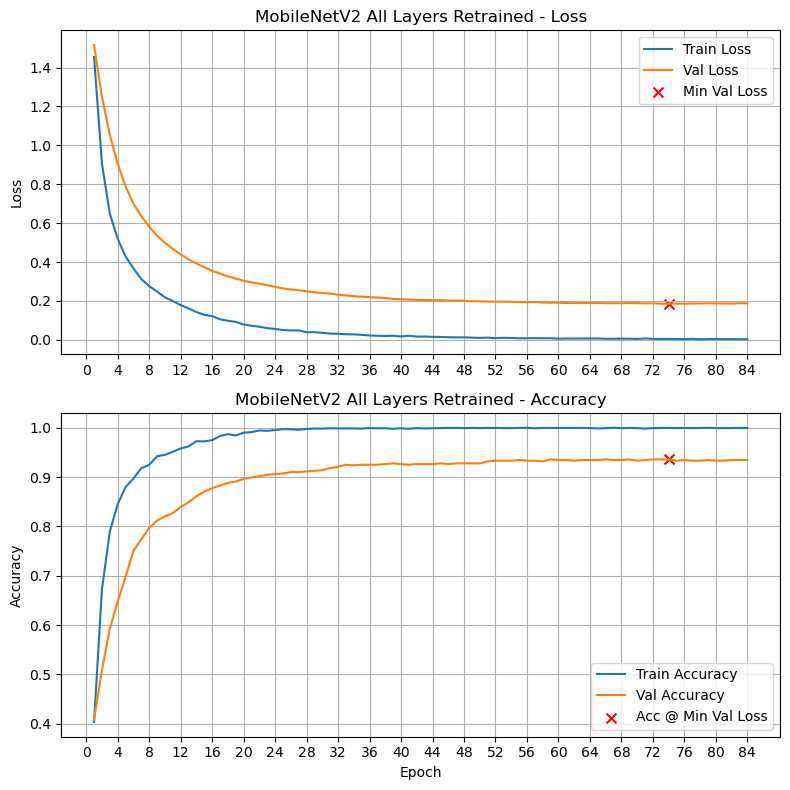

Final Training Loss:            0.0029
Final Training Accuracy:        0.9993
Final Validation Loss:          0.1881
Final Validation Accuracy:      0.9346
Minimum Validation Loss:        0.1858 (Epoch 74)
Validation Accuracy @ Min Loss: 0.9360

Final Validation Accuracy: 0.9360
Best Epoch: 74

Execution Time: 00:24:34


In [12]:
# Load MobileNetV2 base
base_model3 = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3)
                        )

base_model3.trainable = True  # This is in fact the default

# Add classification head
model_03 = models.Sequential([
                                base_model3,
                                layers.GlobalAveragePooling2D(),
                                layers.Dense(num_classes, activation='softmax')  # 5 classes in tf_flowers
                            ])
train_and_test(model_03, train_ds, val_ds,
               lr_schedule=1e-5,
               epochs=epochs,
               title="MobileNetV2 All Layers Retrained"
              )

### Model 4: MobileNetV2 with Top N Layers Retrained



- Only the last N layers of the base are retrained.

- Common in transfer learning: freeze the early layers (generic features), fine-tune deeper ones (task-specific features).

- Good balance of accuracy and generalization.


MobileNetV2 Top 20 Layers Retrained:  lr_schedule: 1e-05



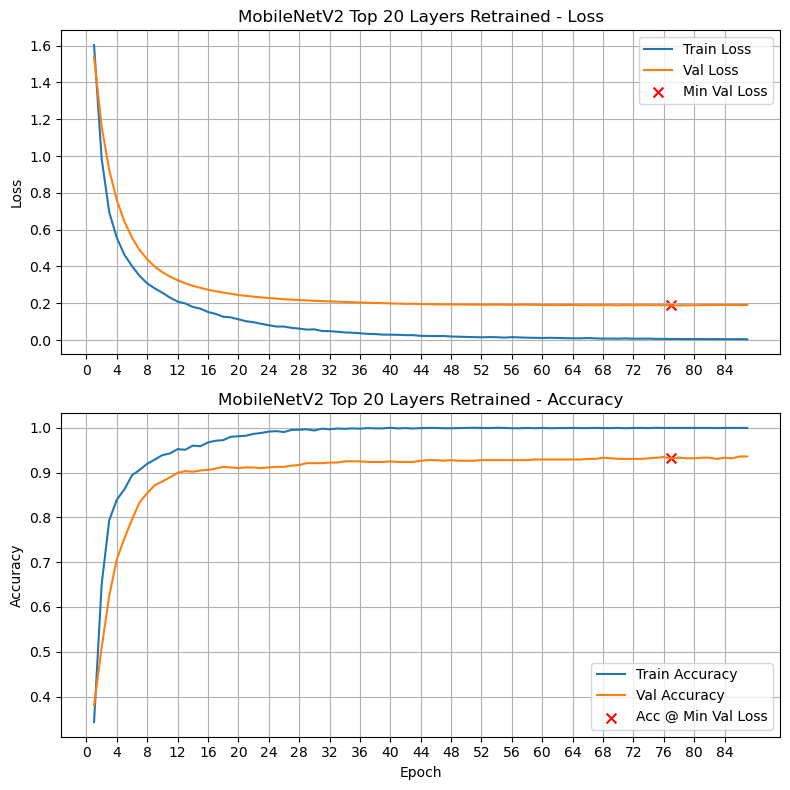

Final Training Loss:            0.0044
Final Training Accuracy:        0.9997
Final Validation Loss:          0.1907
Final Validation Accuracy:      0.9360
Minimum Validation Loss:        0.1887 (Epoch 77)
Validation Accuracy @ Min Loss: 0.9319

Final Validation Accuracy: 0.9319
Best Epoch: 77

Execution Time: 00:04:38


In [13]:
# Load MobileNetV2 base
base_model4 = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3)
                        )

for layer in base_model4.layers[:-20]:                # Again, the default is trainable
    layer.trainable = False

# Add classification head
model_04 = models.Sequential([
                                base_model4,
                                layers.GlobalAveragePooling2D(),
                                layers.Dense(num_classes, activation='softmax')  # 5 classes in tf_flowers
                            ])
train_and_test(model_04, train_ds, val_ds,
               lr_schedule=1e-5,
               epochs=epochs,
               title="MobileNetV2 Top 20 Layers Retrained"
              )

### Model 5: MobileNetV2 with Top N Layers Retrained plus deeper head with dropout

This is a combination of model 2 and 4.


MobileNetV2 20 Layers Retrained & Deeper Head:  lr_schedule: 1e-05



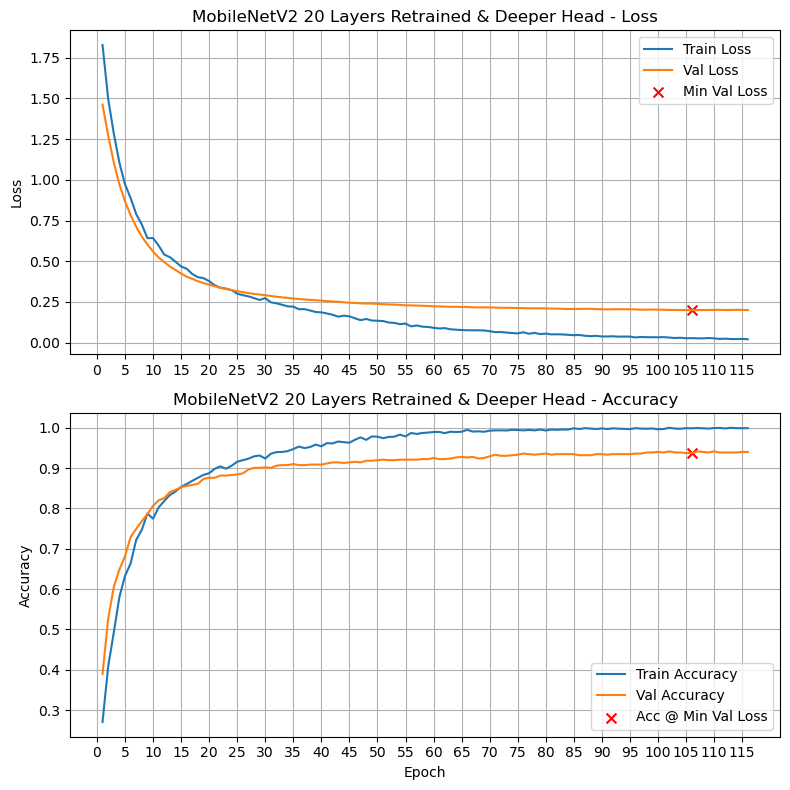

Final Training Loss:            0.0205
Final Training Accuracy:        0.9990
Final Validation Loss:          0.2002
Final Validation Accuracy:      0.9401
Minimum Validation Loss:        0.1997 (Epoch 106)
Validation Accuracy @ Min Loss: 0.9373

Final Validation Accuracy: 0.9373
Best Epoch: 106

Execution Time: 00:07:14


In [21]:
# Load MobileNetV2 base
base_model5 = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3)
                        )

for layer in base_model5.layers[:-20]:
    layer.trainable = False

# Add classification head
model_05 = models.Sequential([  base_model5,
                                layers.GlobalAveragePooling2D(),
                                layers.Dense(512),
                                layers.BatchNormalization(),
                                layers.Activation('relu'),
                                layers.Dropout(0.4),
                                layers.Dense(128),
                                layers.BatchNormalization(),
                                layers.Activation('relu'),
                                layers.Dropout(0.3),
                                layers.Dense(num_classes, activation='softmax')
                            ])
train_and_test(model_05, train_ds, val_ds,
               lr_schedule=1e-5,
               epochs=200,
               title="MobileNetV2 20 Layers Retrained & Deeper Head"
              )





In [22]:
notebook_end = time.time()
print(f"Notebook Execution Time: " + format_hms(notebook_end-notebook_start))

Notebook Execution Time: 01:20:56


In [32]:
# Print out results from the whole notebook

for title in results:
    (acc,ep) = results[title]
    print(f"{title:<40}\t{acc:.4f} @ {ep}")

MobileNetV2 Frozen                      	0.9169 @ 144
MobileNetV2 Frozen & Larger Head with Dropout	0.9387 @ 34
MobileNetV2 All Layers Retrained        	0.9360 @ 74
MobileNetV2 Top 20 Layers Retrained     	0.9360 @ 100
MobileNetV2 20 Layers Retrained & Deeper Head	0.9373 @ 106
